# AAI 520 - Assignment 7 - Final Project
## Topic Modelling

by Bryan Carr

24 October 2022

for University of San Diego, AAI 520 - Natural Language Processing

Prof. Siamak Aram

In this final assignment, we will conduct natural language analysis of some given data - sentences from texts written by a selection of famour authors (Edgar Allen Poe, HP Lovecraft, and Mary W. Shelly). Our goal is to conduct topic modelling, an unsupervised learning technique, to determine how many topics are best described in this body of work (corpus).

We will look at some early EDA from the given dataset. Then we will apply some NLP techniques to standardize and streamline the text sentences, namely tokenization and lemmatization, followed by sequencing. Then we will then vectorize the sequences using count-based and frequency-based techniques. Finally we will apply and compare two topic modelling techniques, latent dirichlet allocaiton (LDA) and non-negative matrix factorization (NMF).

Let's begin by importing the key libraries, and reading the data in. I've pre-loaded the data into my Google drive to support this.

In [ ]:
# Import key libraries

# Standard Data Science packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# NLP packages
import nltk

# for time measurement
from time import time

In [ ]:
# Mount the Google Drive to use the data file
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1. Exploratory Data Analysis

We'll begin by loading in the data and exploring the two data sets (test and train) a bit.

In [ ]:
# read in the Data
train_df = pd.read_csv('/content/drive/My Drive/AAI 520 NLP/train.csv')
test_df = pd.read_csv('/content/drive/My Drive/AAI 520 NLP/test.csv')

In [ ]:
train_df

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL
...,...,...,...
19574,id17718,"I could have fancied, while I looked at it, th...",EAP
19575,id08973,The lids clenched themselves together as if in...,EAP
19576,id05267,"Mais il faut agir that is to say, a Frenchman ...",EAP
19577,id17513,"For an item of news like this, it strikes us i...",EAP


In [ ]:
# Print first 5 Sentences
for i in range(0,5):
  print(train_df.iloc[i][1])

This process, however, afforded me no means of ascertaining the dimensions of my dungeon; as I might make its circuit, and return to the point whence I set out, without being aware of the fact; so perfectly uniform seemed the wall.
It never once occurred to me that the fumbling might be a mere mistake.
In his left hand was a gold snuff box, from which, as he capered down the hill, cutting all manner of fantastic steps, he took snuff incessantly with an air of the greatest possible self satisfaction.
How lovely is spring As we looked from Windsor Terrace on the sixteen fertile counties spread beneath, speckled by happy cottages and wealthier towns, all looked as in former years, heart cheering and fair.
Finding nothing else, not even gold, the Superintendent abandoned his attempts; but a perplexed look occasionally steals over his countenance as he sits thinking at his desk.


In [ ]:
# Let's look at the number of occurences of each author
train_df['author'].value_counts()

EAP    7900
MWS    6044
HPL    5635
Name: author, dtype: int64

In [ ]:
# What is the percentage of Edgar Allen Poe entries?
percent_eap = train_df['author'].value_counts()[0] / train_df.shape[0]
percent_eap

0.40349353899586293

In [ ]:
# What is the percentage of Mary Shelly entries?
percent_mws = train_df['author'].value_counts()[1] / train_df.shape[0]
percent_mws

0.30869809489759437

In [ ]:
# What is the percentage of HP Lovecraft entries?
percent_hpl = train_df['author'].value_counts()[2] / train_df.shape[0]
percent_hpl

0.2878083661065427

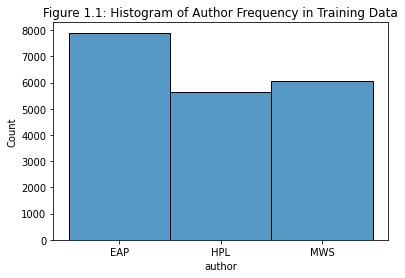

In [ ]:
# Let's create a Histogram for the counts of each author
plt.title("Figure 1.1: Histogram of Author Frequency in Training Data")
sns.histplot(data=train_df, x='author')

There's not much else to explore in this set, without looking at the structure of the sentences and applying NLP techniques to standardize things (for example, counting the number of tokens).

One thing we could look at is the length of the sentences, both in general and broken down by author. Let's measure the Length data, using the built-in len function:

In [ ]:
# Create a Length column, for the length of sentences in terms of characters
# map the Length function onto the data
train_df['char_length'] = train_df['text'].map(len)

train_df

,id,text,author,char_length
0,id26305,"This process, however, afforded me no means of...",EAP,231
1,id17569,It never once occurred to me that the fumbling...,HPL,71
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP,200
3,id27763,How lovely is spring As we looked from Windsor...,MWS,206
4,id12958,"Finding nothing else, not even gold, the Super...",HPL,174
...,...,...,...,...
19574,id17718,"I could have fancied, while I looked at it, th...",EAP,108
19575,id08973,The lids clenched themselves together as if in...,EAP,55
19576,id05267,"Mais il faut agir that is to say, a Frenchman ...",EAP,68
19577,id17513,"For an item of news like this, it strikes us i...",EAP,74


In [ ]:
author_groups = train_df.groupby(by=['author']).describe()
author_groups

char_length                                                          
             count        mean         std   min   25%    50%    75%     max
author                                                                      
EAP         7900.0  142.225949  105.751334  21.0  68.0  115.0  186.0  1533.0
HPL         5635.0  155.843478   82.020647  21.0  98.0  142.0  196.5   900.0
MWS         6044.0  151.659828  126.305008  21.0  84.0  130.0  192.0  4663.0

We can see that the means are all fairly close to one another, in the range 142-156 characters, but the standard deviations have some spread with HPL being the tightest and MWS the most spread out.

Also, we can see some of the entries are quite long. Let's have a look at them, for curiosity's sake.

In [ ]:
# Look up longest EAP sentence:
print(train_df.iloc[ (train_df.loc[train_df['char_length'] == 1533].index[0]), 1])

Burning with the chivalry of this determination, the great Touch and go, in the next 'Tea Pot,' came out merely with this simple but resolute paragraph, in reference to this unhappy affair: 'The editor of the "Tea Pot" has the honor of advising the editor of the "Gazette" that he the "Tea Pot" will take an opportunity in tomorrow morning's paper, of convincing him the "Gazette" that he the "Tea Pot" both can and will be his own master, as regards style; he the "Tea Pot" intending to show him the "Gazette" the supreme, and indeed the withering contempt with which the criticism of him the "Gazette" inspires the independent bosom of him the "TeaPot" by composing for the especial gratification ? of him the "Gazette" a leading article, of some extent, in which the beautiful vowel the emblem of Eternity yet so offensive to the hyper exquisite delicacy of him the "Gazette" shall most certainly not be avoided by his the "Gazette's" most obedient, humble servant, the "Tea Pot." "So much for Buc

In [ ]:
# look up longest HPL sentence:
print(train_df.iloc[ (train_df.loc[train_df['char_length'] == 900].index[0]), 1])

A weak, filtered glow from the rain harassed street lamps outside, and a feeble phosphorescence from the detestable fungi within, shewed the dripping stone of the walls, from which all traces of whitewash had vanished; the dank, foetid, and mildew tainted hard earth floor with its obscene fungi; the rotting remains of what had been stools, chairs, and tables, and other more shapeless furniture; the heavy planks and massive beams of the ground floor overhead; the decrepit plank door leading to bins and chambers beneath other parts of the house; the crumbling stone staircase with ruined wooden hand rail; and the crude and cavernous fireplace of blackened brick where rusted iron fragments revealed the past presence of hooks, andirons, spit, crane, and a door to the Dutch oven these things, and our austere cot and camp chairs, and the heavy and intricate destructive machinery we had brought.


In [ ]:
# Look up the longest MWS sentence:
print(train_df.iloc[ train_df.loc[train_df['char_length'] == 4663].index[0], 1])

Diotima approached the fountain seated herself on a mossy mound near it and her disciples placed themselves on the grass near her Without noticing me who sat close under her she continued her discourse addressing as it happened one or other of her listeners but before I attempt to repeat her words I will describe the chief of these whom she appeared to wish principally to impress One was a woman of about years of age in the full enjoyment of the most exquisite beauty her golden hair floated in ringlets on her shoulders her hazle eyes were shaded by heavy lids and her mouth the lips apart seemed to breathe sensibility But she appeared thoughtful unhappy her cheek was pale she seemed as if accustomed to suffer and as if the lessons she now heard were the only words of wisdom to which she had ever listened The youth beside her had a far different aspect his form was emaciated nearly to a shadow his features were handsome but thin worn his eyes glistened as if animating the visage of decay

The EAP and MWS entries are clearly combinations of sentences, lacking punctuation. We could address this with sequencing, however that is beyond the scope of this project. (Sequencing would be useful in creating a sentence classifier.)

Lastly let's take a quick look at the Test Data:

In [ ]:
# Let's take a quick look at the Test Data before moving on
test_df

,id,text
0,id02310,"Still, as I urged our leaving Ireland with suc..."
1,id24541,"If a fire wanted fanning, it could readily be ..."
2,id00134,And when they had broken down the frail door t...
3,id27757,While I was thinking how I should possibly man...
4,id04081,I am not sure to what limit his knowledge may ...
...,...,...
8387,id11749,All this is now the fitter for my purpose.
8388,id10526,I fixed myself on a wide solitude.
8389,id13477,It is easily understood that what might improv...
8390,id13761,"Be this as it may, I now began to feel the ins..."


## 2. Standardizing the Entries with Natural Language Processing Techniques.

The next stage of the project is to prepare the data for our LDA and NMF models. LDA will require a Count Vectorizer to turn the strings into word frequency vectors; NMF requires a TF-IDF vectorizer. So we will proceed in three stages:

1) Build a function to standardize the strings

2) Build the two vectorizers

3) Apply both methods to pre-process



### 2.1. Standardizing String inputs

We will now build the string preprocessing function. This will aim to standardize the strings, but applying a series of NLP techniques. Specifically we will want to:

1) process the strings as Lower Case

2) Remove Stop Words and Punctuation

3) Tokenize the strings

4) Further reduce the tokens with Lemmatization and

Due to the string-based nature of our entries, using NLTK is quite appropriate here.

In [ ]:
# Helper Functions for Cleaning Pipeline funciton

# String Remomal with MakeTrans -- translate all Punctuation into blanks
import string
table = str.maketrans('', '', string.punctuation)

# Import NLTK Tokenizer
from nltk import word_tokenize

# Download and prepare NLTK Stop Words
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = stopwords.words('english')

#download nltk punkt
nltk.download('punkt')

# import NLTK Lemmatizer
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.stem.wordnet import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()


# import NLTK Stemmer
from nltk.stem.lancaster import LancasterStemmer
stemmer = LancasterStemmer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [ ]:
"""
Clean_Text function: to pre-process the text by:
1) Converting to Lower Case
2) Removing Stop Words and Punctuation
3) Tokenize
4) Lemmatize
5) Stem
6) Recombine to Sentence
Note: Some code copied from J. Brownlee (2017), notably rmeoving punctuation and numbers

Input: doc_text (string): Document to be converted

Return: sent (string):

Raises: TypeError - if the input is not a String
"""

def clean_text(doc_text):
  # Raise a TypeError if not a string
  if type(doc_text) is not str:
    raise TypeError("The input must be a dtpye String")

  # Convert to Lower Case
  doc_text = doc_text.lower()

  # Tokenize using nltk
  tokens = word_tokenize(doc_text)

  # Remove Punctuation
  stripped = [w.translate(table) for w in tokens]

  # remove remaining tokens that are not alphabetic
  cleaned = [word for word in stripped if word.isalpha()]

  # Remove Stopwords
  no_stops = [word for word in cleaned if word not in stop_words]

  # Stem words
  stems = [stemmer.stem(word) for word in no_stops]

  # Lemmatize
  lemmas = [lemmatizer.lemmatize(word) for word in stems]

  # Rebuild list into string
  sent = ' '.join(lemmas)

  return sent


In [ ]:
# Testing our Clean-Text function
# Create a Testing string, then run it through the function

test_doc = "This string is for testing, some of the SPACY functions; I will widely employ it somewhat"

clean_text(test_doc)

'string test spacy funct wid employ somewh'

Our function seems to be working well, returning a string, as appropriate for the Scikit-Learn Word Classifiers. We will now pre-process the Training and Testing data.

### 2.2: Building Count Vectorizer and TF-IDF Vectorizer

The LDA and NMF models work best with different vectorizations. LDA requires pure counts/frequencies; NMF works well with

In [ ]:
# Import the packages
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [ ]:
# build the Count Vectorizer
count_vectorizer = CountVectorizer(
    input='content',
    max_df = 0.95,
    min_df = 3
)

In [ ]:
# Build the TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(
    input='content',
    max_df=0.95,
    min_df=3
)

### 2.3: Applying our functions to pre-process the data

In [ ]:
# Pre-Process step one: Apply Clean_Text funct to our data, and break into Train and Test dataframes

x_train = None
x_train = pd.DataFrame(train_df.loc[:, 'text'].map(clean_text))

print(x_train.head())

x_test = None
x_test = pd.DataFrame(test_df.loc[:, 'text'].map(clean_text))

print(x_test.head())

                                                text
0  process howev afford mean ascertain dimend dun...
1                   nev occur fumbl might mer mistak
2  left hand gold snuff box cap hil cut man fanta...
3  lov spring look wind terrac sixteen fertil cou...
4  find noth el ev gold superintend abandon attem...
                                                text
0  stil urg leav ireland inquietud impaty fath th...
1  fir want fan could ready fan newspap govern gr...
2  brok frail door found two cle pick hum skeleto...
3  think po man without on act tumbl head rol ste...
4                      sur limit knowledg may extend


In [ ]:
y_train = pd.DataFrame(train_df.loc[:,'author'])
y_train

,author
0,EAP
1,HPL
2,EAP
3,MWS
4,HPL
...,...
19574,EAP
19575,EAP
19576,EAP
19577,EAP


In [ ]:
# Fit_Transform Vectorizers

x_train_cv = count_vectorizer.fit_transform(x_train['text'])

x_train_cv

<19579x6910 sparse matrix of type '<class 'numpy.int64'>'
	with 240578 stored elements in Compressed Sparse Row format>

In [ ]:
# Fit_Transform TF-IDF Vectorizer

x_train_tfidf = tfidf_vectorizer.fit_transform(x_train['text'])

x_train_tfidf

<19579x6910 sparse matrix of type '<class 'numpy.float64'>'
	with 240578 stored elements in Compressed Sparse Row format>

## 3. LDA and NMF Topic Modelling

Time to build and fit our two topic modelling systems.

We will evaluate with several different numbers of topics, using the perplexity score. Perplexity is simply e^(Cross Entropy), so smaller scores are better as they indicate less entropy, and therefore more distinct topics.

In [ ]:
# Import models
from sklearn.decomposition import LatentDirichletAllocation, NMF


In [ ]:
# Build a loop to evaluate LDA with different numbers of topics

lda_results = pd.DataFrame(columns=['n', 'perp', 'run_time'])
for i in range (0,10):
  t0 = time()
  n = i + 2
  lda = LatentDirichletAllocation(n_components=n, random_state=1024)

  lda.fit(x_train_cv)

  perp = lda.perplexity(x_train_cv)
  print('n = ' + str(n) + '     perplexity = ' + str(perp))

  lda_results.loc[i] = [n, perp, (time()-t0)]

lda_results

n = 2     perplexity = 2680.706707315594
n = 3     perplexity = 2706.2071373036993
n = 4     perplexity = 2816.5420582241036
n = 5     perplexity = 2893.6253280317223
n = 6     perplexity = 2991.382374930712
n = 7     perplexity = 3069.5898077224615
n = 8     perplexity = 3118.5595736022706
n = 9     perplexity = 3190.828125097942
n = 10     perplexity = 3276.7377749385864
n = 11     perplexity = 3317.741676853357


,n,perp,run_time
0,2.0,2680.706707,72.064593
1,3.0,2706.207137,78.245501
2,4.0,2816.542058,66.810627
3,5.0,2893.625328,65.574191
4,6.0,2991.382375,61.287080
5,7.0,3069.589808,62.079962
6,8.0,3118.559574,58.332960
7,9.0,3190.828125,58.888936
8,10.0,3276.737775,62.896748
9,11.0,3317.741677,56.430102


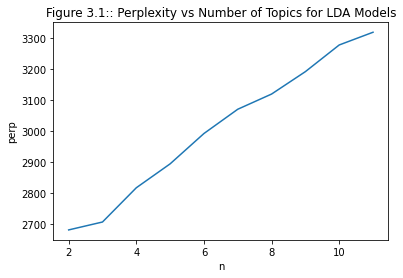

In [ ]:
# Plot the results for LDA

plt.title("Figure 3.1:: Perplexity vs Number of Topics for LDA Models")
sns.lineplot(data=lda_results, x='n', y='perp')

We can clearly see perplexity increaseing with the number of topics -- therefore n=2 topics is the best model we have for LDA.

Let's retrain it, and have a look at the two sets of topics.

In [ ]:
# Build and train the model with n=2 Topics
lda2 = LatentDirichletAllocation(n_components=2, random_state=1024)

lda2.fit(x_train_cv)

LatentDirichletAllocation(n_components=2, random_state=1024)

In [ ]:
# Print out top 20 word tokens in the LDA2 model

for i, topic in enumerate(lda2.components_):
  print(f'THE TOP 20 WORDS FOR TOPIC #{i}')
  print([count_vectorizer.get_feature_names_out()[w] for w in topic.argsort()[-20:]])
  print('\n')


THE TOP 20 WORDS FOR TOPIC #0
['door', 'room', 'near', 'look', 'found', 'first', 'ey', 'two', 'tim', 'gre', 'man', 'op', 'lik', 'hous', 'thing', 'seem', 'old', 'could', 'on', 'upon']


THE TOP 20 WORDS FOR TOPIC #1
['nev', 'friend', 'heart', 'mad', 'might', 'tim', 'thought', 'pas', 'long', 'nat', 'lif', 'said', 'man', 'day', 'lov', 'yet', 'on', 'could', 'would', 'ev']




Even acknowledging that these are the word lemmas and thus difficult to read, it's difficult to see the common thread in these topics. The first seems to deal with objects and structures (thing, house, room, etc.) and the second with feelings (love, friend, heart, mad, etc.), but those are quite loose connections.

Let's move on to the NMF modelling. We will use the reconstruction error as our evaluation metric.

In [ ]:
# Build a loop to evaluate LDA with different numbers of topics

nmf_results = pd.DataFrame(columns=['n', 'rec_err', 'run_time'])
for i in range (0,20):
  t0 = time()
  n = i + 2
  nmf = NMF(n_components=n, random_state=1024, init='nndsvda', max_iter=500)

  nmf.fit(x_train_tfidf)

  err = nmf.reconstruction_err_
  print('n = ' + str(n) + '     reconstruction error = ' + str(err))

  nmf_results.loc[i] = [n, err, (time()-t0)]

nmf_results

n = 2     reconstruction error = 139.14616033987298
n = 3     reconstruction error = 138.9872073724234
n = 4     reconstruction error = 138.82129488285503
n = 5     reconstruction error = 138.664512818084
n = 6     reconstruction error = 138.49708372622692
n = 7     reconstruction error = 138.33990334537538
n = 8     reconstruction error = 138.19501529782116
n = 9     reconstruction error = 138.05353791084588
n = 10     reconstruction error = 137.9223865015758
n = 11     reconstruction error = 137.79497936616994
n = 12     reconstruction error = 137.6725486723791
n = 13     reconstruction error = 137.552281683596
n = 14     reconstruction error = 137.43067936286232


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,


n = 15     reconstruction error = 137.3130052428271
n = 16     reconstruction error = 137.19376599405194
n = 17     reconstruction error = 137.0745730252235
n = 18     reconstruction error = 136.96182681428976
n = 19     reconstruction error = 136.86010949249604
n = 20     reconstruction error = 136.73520657860794
n = 21     reconstruction error = 136.6212412868684


,n,rec_err,run_time
0,2.0,139.146160,0.356681
1,3.0,138.987207,0.583840
2,4.0,138.821295,0.865997
3,5.0,138.664513,0.838811
4,6.0,138.497084,0.629534
5,7.0,138.339903,0.998682
6,8.0,138.195015,0.957159
7,9.0,138.053538,1.288674
8,10.0,137.922387,2.017508
9,11.0,137.794979,2.555183


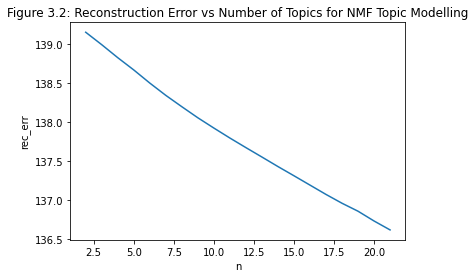

In [ ]:
# plot error against number of components

plt.title("Figure 3.2: Reconstruction Error vs Number of Topics for NMF Topic Modelling")
sns.lineplot(data=nmf_results, x='n', y='rec_err')

Although the graph looks steep, we can see that the error is only declining very slightly, from 139.15 to 136.62.

We can also see a sharp increase in the time required to run the computation at N=14. Therefore we should consider evaluating 14 topics.

Let's have a look at the topics from a NMF model with 2 topics, to compare with our LDA, as well as the aforementionned 14 topics.

In [ ]:
# build NMF2 and show topics
nmf2 = NMF(n_components=2, random_state=1024, init='nndsvda', max_iter=500)

nmf2.fit(x_train_tfidf)

NMF(init='nndsvda', max_iter=500, n_components=2, random_state=1024)

In [ ]:
# Print out top 20 word tokens in the NMF2 model

for i, topic in enumerate(nmf2.components_):
  print(f'THE TOP 20 WORDS FOR TOPIC #{i}')
  print([tfidf_vectorizer.get_feature_names_out()[w] for w in topic.argsort()[-20:]])
  print('\n')

THE TOP 20 WORDS FOR TOPIC #0
['gre', 'first', 'pas', 'thought', 'lov', 'must', 'nev', 'ey', 'day', 'long', 'thing', 'mad', 'yet', 'said', 'tim', 'man', 'upon', 'would', 'could', 'ev']


THE TOP 20 WORDS FOR TOPIC #1
['mom', 'hand', 'found', 'singul', 'op', 'ent', 'smal', 'window', 'might', 'seen', 'day', 'hous', 'sid', 'night', 'every', 'old', 'thing', 'anoth', 'two', 'on']




We can see that the first topic is fairly close to the second from LDA, containing several 'feeling' words. The second of these NMF topics is quite on its own, containing day, night; house, window, and thing. Both are even less coherent than the LDA topics, by my quick reading.

Lastly, let's have a look at the 14-topic NMF model to see if anything is clearer.

In [ ]:
# Build NMF 14 and show topics
nmf14 = NMF(n_components=14, random_state=1024, init='nndsvda', max_iter=600)

nmf14.fit(x_train_tfidf)

NMF(init='nndsvda', max_iter=600, n_components=14, random_state=1024)

In [ ]:
# Print out top 20 word tokens in the LDA14 model

for i, topic in enumerate(nmf14.components_):
  print(f'THE TOP 20 WORDS FOR TOPIC #{i}')
  print([count_vectorizer.get_feature_names_out()[w] for w in topic.argsort()[-20:]])
  print('\n')

THE TOP 20 WORDS FOR TOPIC #0
['every', 'wel', 'tak', 'mat', 'year', 'many', 'mind', 'part', 'much', 'thought', 'appear', 'found', 'howev', 'might', 'gre', 'first', 'day', 'long', 'mad', 'tim']


THE TOP 20 WORDS FOR TOPIC #1
['point', 'top', 'arm', 'tabl', 'found', 'depend', 'lay', 'effect', 'charact', 'let', 'word', 'thrown', 'sat', 'subject', 'head', 'thu', 'fel', 'look', 'hand', 'upon']


THE TOP 20 WORDS FOR TOPIC #2
['exceiv', 'smal', 'end', 'writ', 'dea', 'ent', 'voic', 'let', 'reply', 'mom', 'word', 'singul', 'seen', 'might', 'sid', 'old', 'every', 'two', 'anoth', 'on']


THE TOP 20 WORDS FOR TOPIC #3
['pound', 'wel', 'heard', 'thousand', 'stil', 'sur', 'mean', 'com', 'go', 'friend', 'tak', 'dear', 'ye', 'word', 'sir', 'noth', 'let', 'littl', 'dupin', 'said']


THE TOP 20 WORDS FOR TOPIC #4
['form', 'imagin', 'po', 'understand', 'knew', 'tel', 'scarc', 'reason', 'doubt', 'don', 'hum', 'help', 'mak', 'believ', 'perceiv', 'distinct', 'see', 'word', 'noth', 'could']


THE TOP 20 W

These topics appear to be largely unintelligible and unrelated. This shows us one of the downsides of NMF, which is that it often results in less coherent topics.

## 4. Conclusions

We applied natural language processing techniques to conduct topic modelling of the requested data. We found that two topics was the best split for LDA, with the lowest perplexity (a representaiton of cross entropy), and saw increasing perplexity with every topic added in a relatively linear way.

For NMF, we observed a linear decrease in the reconstruction error with increasing number of topics (a measure of how close we can get to the original values with our lower dimensional word vectors). However, this drop was quite small. Further, NMF appears to give us less useful collections of words for topics, at the benefit of running much much faster.

## 5. References

Brownlee, J. (2017, October 18). How to Clean Text for Machine Learning with Python. MachineLearningMastery.com. https://machinelearningmastery.com/clean-text-machine-learning-python/